In [36]:
import pandas as pd
import torch.nn as nn
from training_utils import early_stopped_tbnn_training_run, early_stopped_mlp_training_run
import torch
import matplotlib.pyplot as plt
import pickle
import torch.nn as nn



In [37]:
dataset_params = {'file': '/home/ryley/WDK/ML/dataset/komegasst_split.csv',
                  'test_set': ['fp_3630'],
                }

df = pd.read_csv(dataset_params['file'])

df = df[df['Case'].isin(['fp_3630', 'fp_3970','fp_4060'])]

df_test = df[df['Case'].isin(dataset_params['test_set'])]
df_tv = df[~df['Case'].isin(dataset_params['test_set'])]
print(f'Dataset: {len(df)}, test: {len(df_test)}, tv: {len(df_tv)}')



Dataset: 511, test: 168, tv: 343


Training points: 171, validation points 172
EPOCH    LR        TRAIN     VALID         MSE:T/V              RL:T/V         %NR_t/%NR_v
  1   1.000e-03   0.03245   0.03230   0.03244 / 0.03229   0.00001 / 0.00001   81.29% / 81.40%
 10   9.910e-04   0.02572   0.02561   0.02572 / 0.02561   0.00000 / 0.00000   5.85% / 3.49%
 20   9.812e-04   0.01009   0.00987   0.00999 / 0.00986   0.00010 / 0.00002   71.93% / 65.70%
 30   9.714e-04   0.00772   0.00769   0.00772 / 0.00769   0.00000 / 0.00000   0.00% / 0.00%
 40   9.617e-04   0.00636   0.00634   0.00636 / 0.00634   0.00000 / 0.00000   12.28% / 0.00%
 50   9.522e-04   0.00602   0.00600   0.00602 / 0.00600   0.00000 / 0.00000   0.00% / 0.00%
 60   9.427e-04   0.00587   0.00585   0.00587 / 0.00585   0.00000 / 0.00000   0.00% / 0.00%
 70   9.333e-04   0.00576   0.00574   0.00576 / 0.00574   0.00000 / 0.00000   0.00% / 2.33%
 80   9.240e-04   0.00567   0.00565   0.00567 / 0.00565   0.00000 / 0.00000   0.00% / 12.21%
 90   9.148e-04   0.00559   0.0

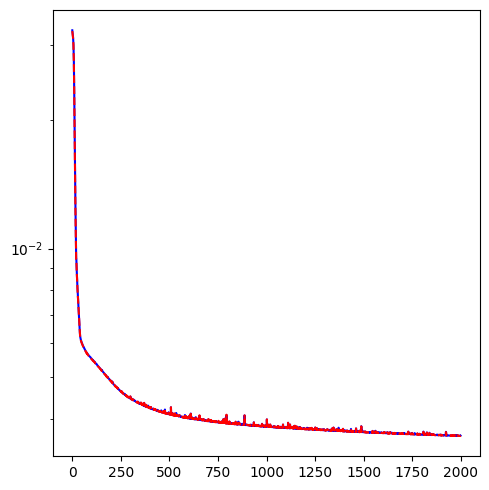

In [44]:
training_params = {'early_stopping_patience': 500,
                    'max_epochs': 2000,
                      'learning_rate': 0.001,
                        'learning_rate_decay': 0.999,
                          'batch_size': 32,
                            'val_set': ['fp_4060']}

model_params = {'neurons': 20, 'n_hidden': 7, 'activation_function': nn.SiLU(),                 
                #'input_features': ['komegasst_q6','komegasst_q5','komegasst_I1_1','komegasst_I1_3','komegasst_I2_3','komegasst_I1_5']
                'input_features':['komegasst_I1_1',
'komegasst_I1_3',
'komegasst_I1_4',
'komegasst_I1_5',
#'komegasst_I1_16',
#'komegasst_I1_7',
#'komegasst_I1_9',
#'komegasst_I1_10',
#'komegasst_I1_12',
#'komegasst_I1_13',
#'komegasst_I1_16',
'komegasst_q5',
#'komegasst_q6',
]
}


model, loss_vals, val_loss_vals  = early_stopped_tbnn_training_run(model_params,training_params,df_tv)


fig, ax = plt.subplots(1,figsize=(5,5))
ax.plot(loss_vals,'-',color='b')
ax.plot(val_loss_vals,'--',color='r')
ax.semilogy()
fig.tight_layout()
#fig.savefig(f'models/model_cluster_{cluster}.png',dpi=300)

In [46]:
import training_utils
import numpy as np
from torch.utils.data import Dataset, DataLoader

df_train = df[~df['Case'].isin(dataset_params['test_set']+training_params['val_set'])]
#df_test = df[df['Case'].isin(test_set)].copy()


df_test[f'pred_b_11_all'] = np.zeros(len(df_test))
df_test[f'pred_b_12_all'] = np.zeros(len(df_test))
df_test[f'pred_b_13_all'] = np.zeros(len(df_test))
df_test[f'pred_b_22_all'] = np.zeros(len(df_test))
df_test[f'pred_b_23_all'] = np.zeros(len(df_test))
df_test[f'pred_b_33_all'] = np.zeros(len(df_test))


#model_params = pickle.load(open(f"models/params_cluster_all.pickle", "rb"))
#df_train_i = df_train[df_train['Cluster'] == cluster]
#df_test_i = df_test[df_test['Cluster'] == cluster].copy()

tDs = training_utils.bDataset(df_train, input_features=model_params['input_features'])
testDs = training_utils.bDataset(df_test, input_features=model_params['input_features'],scaler = tDs.X_scaler)

model.eval()
for X, T, y in DataLoader(testDs, shuffle=False, batch_size=testDs.__len__()):
    y_pred_test, gn = model(X,T)
    print(f"loss: {training_utils.bLoss(y_pred_test,y)}")
    print(f"loss: {training_utils.mseLoss(y_pred_test,y)}")

    print(f"loss: {training_utils.realizLoss(y,y)}")
    print(f"loss: {training_utils.realizLoss_components(y,y)}")
    print(f"loss: {training_utils.realizLoss_eig(y,y)}")
    print(f"loss: {training_utils.realizLoss_eig1(y,y)}")
    print(f"loss: {training_utils.realizLoss_eig2(y,y)}")

    #val_loss_values.append(loss_fn(y_pred_val,y).item())   
    #mse_v = mseLoss(y_pred_val,y).item()  
    #rl_v = realizLoss(y_pred_val,y).item()
#for prediction_name in ['pred_b_11','pred_b_12','pred_b_13','pred_b_22','pred_b_23','pred_b_33']:
print(y_pred_test.shape)
df_test[f'pred_b_11_all'] = y_pred_test[:,0,0].detach().numpy()
df_test[f'pred_b_12_all'] = y_pred_test.detach().numpy()[:,0,1]
df_test[f'pred_b_13_all'] = y_pred_test.detach().numpy()[:,0,2]
df_test[f'pred_b_22_all'] = y_pred_test.detach().numpy()[:,1,1]
df_test[f'pred_b_23_all'] = y_pred_test.detach().numpy()[:,1,2]
df_test[f'pred_b_33_all'] = y_pred_test.detach().numpy()[:,2,2]

df_test[f'pred_g1'] = gn[:,0].detach().numpy()
df_test[f'pred_g2'] = gn[:,1].detach().numpy()
df_test[f'pred_g3'] = gn[:,2].detach().numpy()
df_test[f'pred_g4'] = gn[:,3].detach().numpy()
df_test[f'pred_g5'] = gn[:,4].detach().numpy()
df_test[f'pred_g6'] = gn[:,5].detach().numpy()
df_test[f'pred_g7'] = gn[:,6].detach().numpy()
df_test[f'pred_g8'] = gn[:,7].detach().numpy()
df_test[f'pred_g9'] = gn[:,8].detach().numpy()
df_test[f'pred_g10'] = gn[:,9].detach().numpy()



loss: 0.0037689630407840014
loss: 0.0037645543925464153
loss: 0.0
loss: 0.0
loss: 0.0
loss: 0.0
tensor([[ 0.3508, -0.0175, -0.3333],
        [ 0.3561, -0.0228, -0.3333],
        [ 0.3594, -0.0261, -0.3333],
        [ 0.3671, -0.0339, -0.3332],
        [ 0.3701, -0.0370, -0.3332],
        [ 0.3782, -0.0451, -0.3331],
        [ 0.3824, -0.0494, -0.3330],
        [ 0.3888, -0.0559, -0.3329],
        [ 0.3948, -0.0621, -0.3327],
        [ 0.3986, -0.0660, -0.3327],
        [ 0.4061, -0.0737, -0.3325],
        [ 0.4117, -0.0794, -0.3323],
        [ 0.4156, -0.0834, -0.3322],
        [ 0.4229, -0.0909, -0.3320],
        [ 0.4283, -0.0966, -0.3318],
        [ 0.4325, -0.1009, -0.3316],
        [ 0.4389, -0.1075, -0.3314],
        [ 0.4442, -0.1130, -0.3312],
        [ 0.4484, -0.1174, -0.3310],
        [ 0.4536, -0.1229, -0.3307],
        [ 0.4586, -0.1282, -0.3305],
        [ 0.4628, -0.1325, -0.3303],
        [ 0.4669, -0.1369, -0.3300],
        [ 0.4713, -0.1416, -0.3297],
        [ 0.4750

/tmp/ipykernel_51508/3787156401.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f'pred_b_11_all'] = np.zeros(len(df_test))
/tmp/ipykernel_51508/3787156401.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f'pred_b_12_all'] = np.zeros(len(df_test))
/tmp/ipykernel_51508/3787156401.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

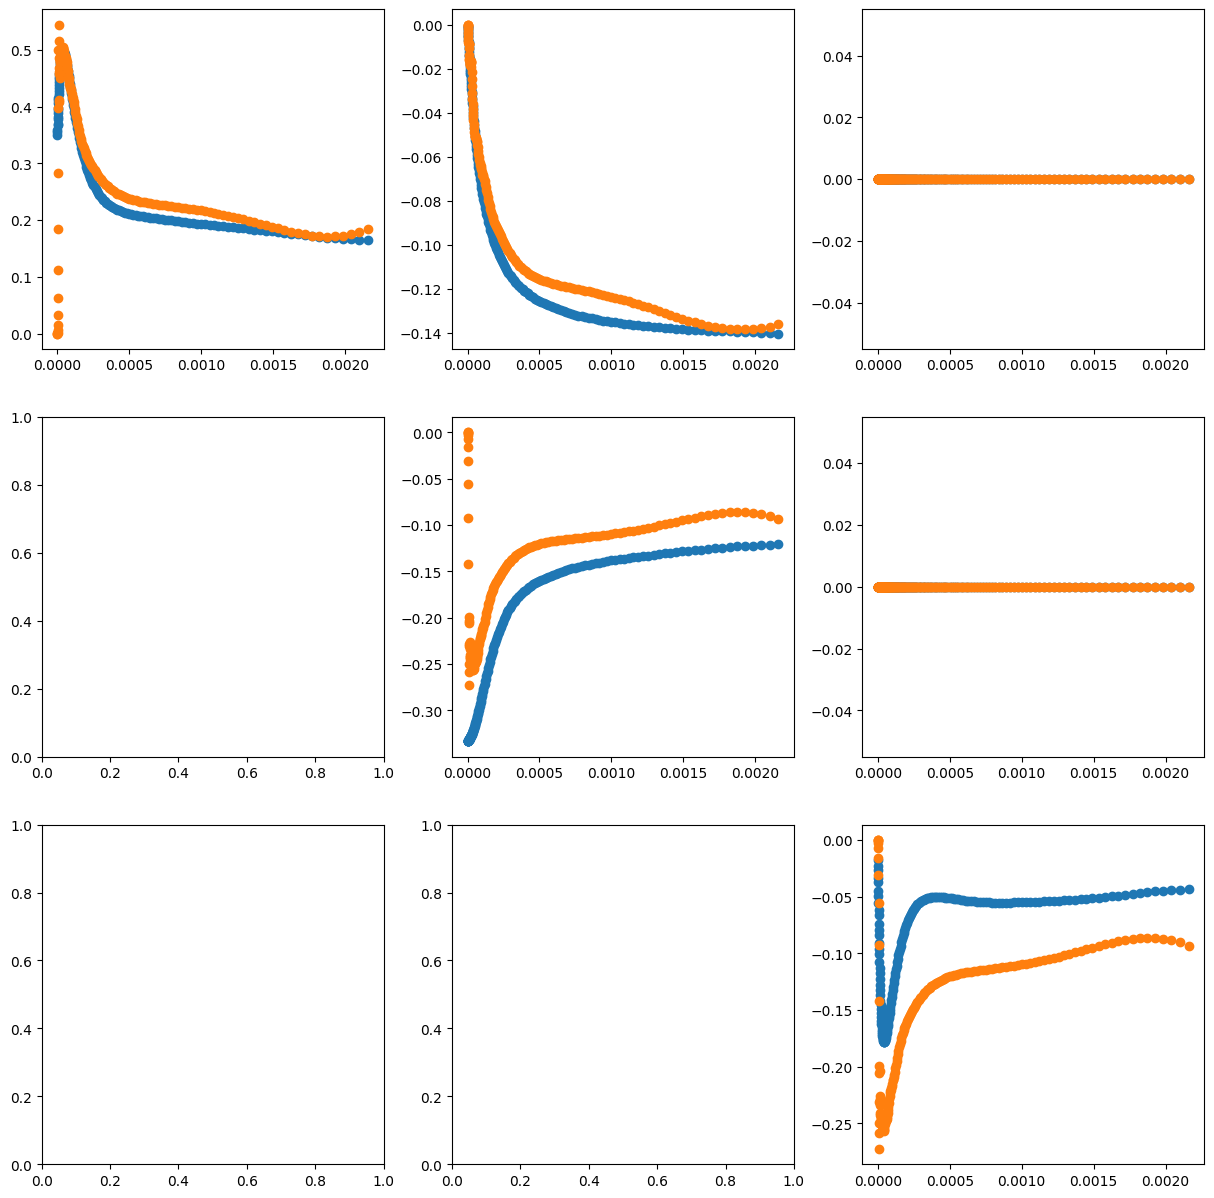

In [47]:
fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(15,15))
axs[0,0].scatter(df_test['komegasst_C_2'],df_test['DNS_b_11'])
axs[0,0].scatter(df_test['komegasst_C_2'],df_test['pred_b_11_all'])

axs[0,1].scatter(df_test['komegasst_C_2'],df_test['DNS_b_12'])
axs[0,1].scatter(df_test['komegasst_C_2'],df_test['pred_b_12_all'])

axs[0,2].scatter(df_test['komegasst_C_2'],df_test['DNS_b_13'])
axs[0,2].scatter(df_test['komegasst_C_2'],df_test['pred_b_13_all'])

axs[1,1].scatter(df_test['komegasst_C_2'],df_test['DNS_b_22'])
axs[1,1].scatter(df_test['komegasst_C_2'],df_test['pred_b_22_all'])

axs[1,2].scatter(df_test['komegasst_C_2'],df_test['DNS_b_23'])
axs[1,2].scatter(df_test['komegasst_C_2'],df_test['pred_b_23_all'])

axs[2,2].scatter(df_test['komegasst_C_2'],df_test['DNS_b_33'])
axs[2,2].scatter(df_test['komegasst_C_2'],df_test['pred_b_33_all'])

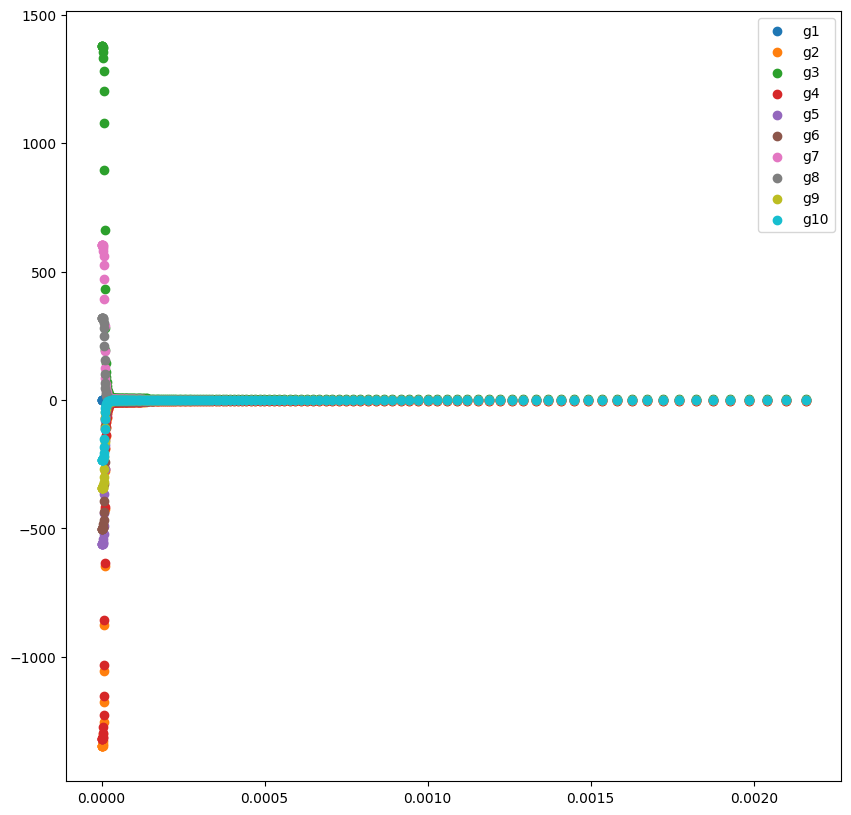

In [41]:
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g1'],label='g1')
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g2'],label='g2')
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g3'],label='g3')
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g4'],label='g4')
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g5'],label='g5')
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g6'],label='g6')
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g7'],label='g7')
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g8'],label='g8')
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g9'],label='g9')
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g10'],label='g10')
axs.legend()



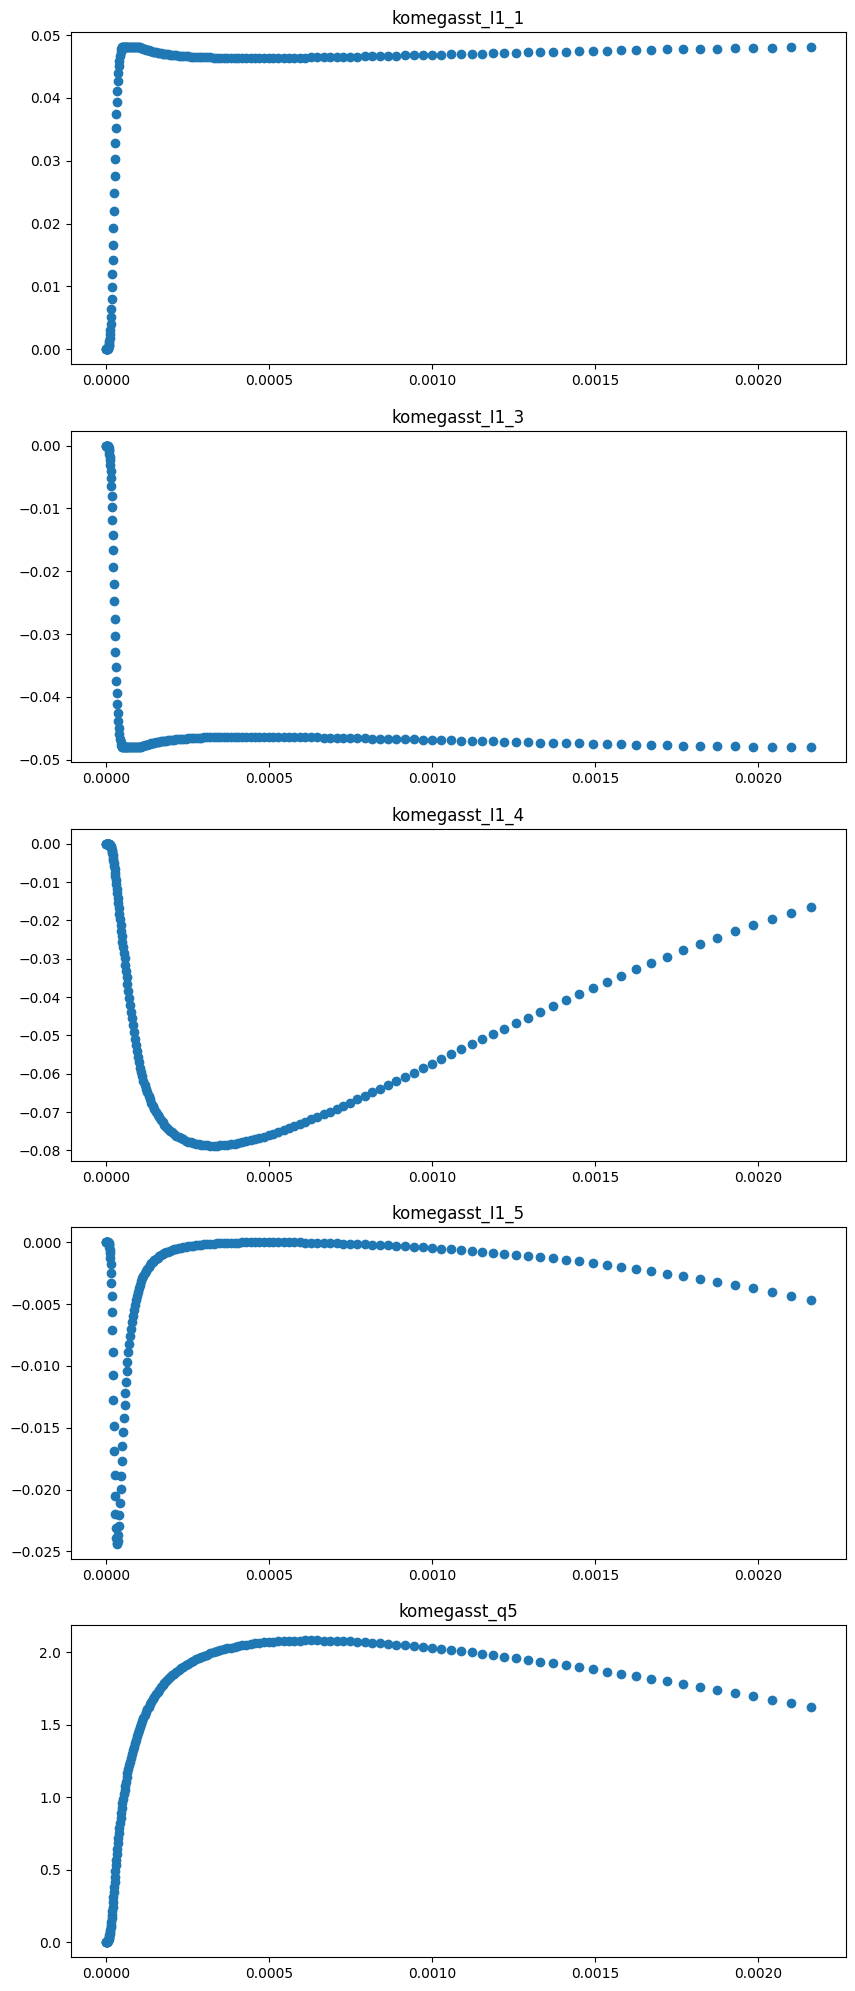

In [42]:
fig, axs = plt.subplots(nrows=len(model_params['input_features']),ncols=1,figsize=(10,len(model_params['input_features'])*5))
for i, ax in enumerate(axs):
    ax.scatter(df_test['komegasst_C_2'],df_test[model_params['input_features'][i]])
    ax.set_title(model_params['input_features'][i])


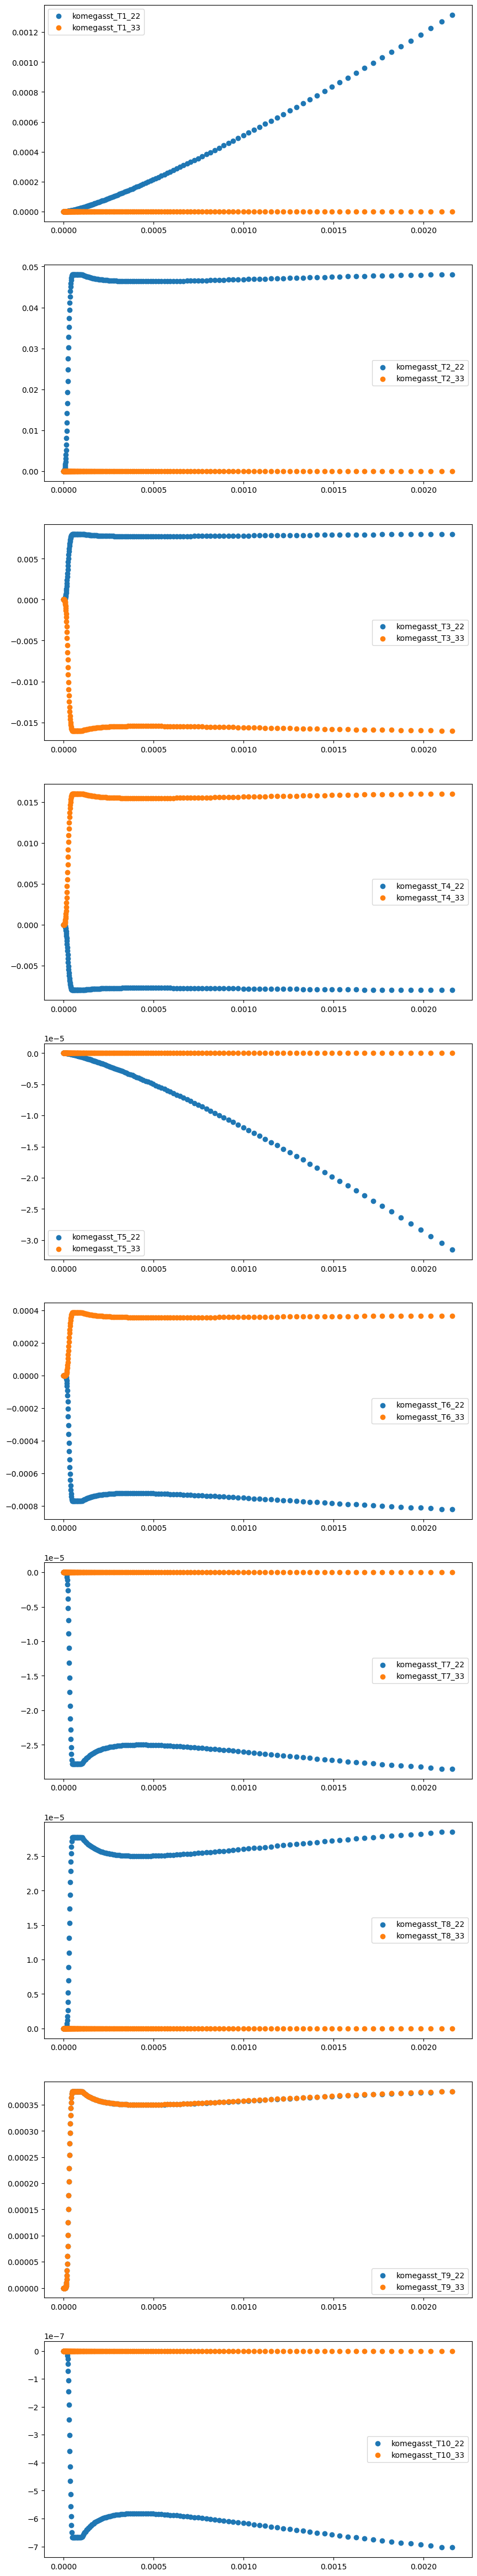

In [43]:
fig, axs = plt.subplots(nrows=10,ncols=1,figsize=(10,60))
for i,ax in enumerate(axs):
    ax.scatter(df_test['komegasst_C_2'],df_test[f'komegasst_T{i+1}_22'],label=f'komegasst_T{i+1}_22')
    ax.scatter(df_test['komegasst_C_2'],df_test[f'komegasst_T{i+1}_33'], label = f'komegasst_T{i+1}_33')
    ax.legend()
